In [362]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from c_Population_graph.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
from overpresented_patterns import calculate_relative_presentation

### Parameters

In [383]:
iteration = 1
PhenoGraph_k =  100

In [384]:
# Retrive cluster data
FILE_NAMES = os.listdir(
    os.path.join(PROJECT_ROOT, "Output", "b_Soft_WL_Kernel", "Danenberg", "Cohort_1", 'Subtrees')
)
X = []
Cluster_identities = []
Indices = []
for i in range(len(FILE_NAMES)):
    file_name = FILE_NAMES[i]
    x = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_1",
            "Subtrees",
            file_name,
            "neighborhood_aggregation",
            "X" + str(iteration) + ".npy",
        )
    )
    cluster_identities = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_1",
            "Subtrees",
            file_name,
            "pattern_ids",
            "pattern_id_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".npy",
        )
    )
    indices = np.zeros(x.shape[0], dtype=int)
    indices[:] = i

    Indices.append(indices)
    X.append(x)
    Cluster_identities.append(cluster_identities)
X = np.concatenate(X, axis=0)
Cluster_identities = np.concatenate(Cluster_identities, axis=0)
Indices = np.concatenate(Indices, axis=0)

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<AxesSubplot: >

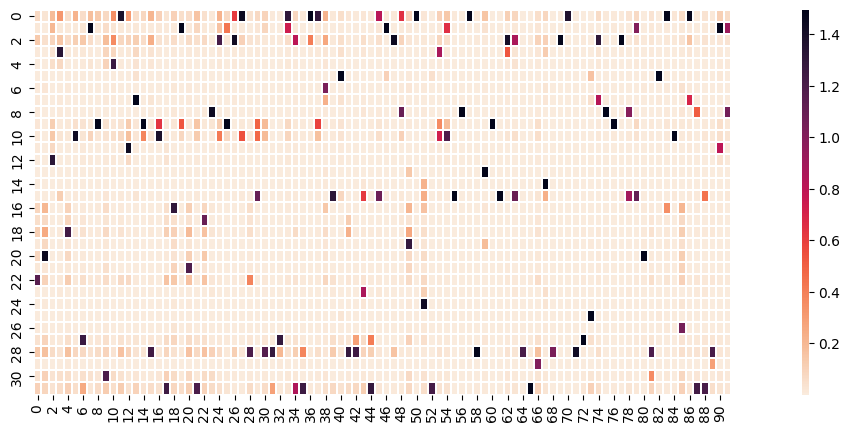

In [385]:
from b_Soft_WL_Kernel.SoftWL import compute_cluster_centroids
from definitions import get_cell_phenotype_id

Centroids = compute_cluster_centroids(X, Cluster_identities)
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=30, random_state=0).fit(Centroids)
f, (ax, cbar_ax) = plt.subplots(1,2,figsize=(10,5),gridspec_kw= {"width_ratios": [20,0.2]} )
sns.heatmap(
            Centroids.T,
            ax=ax,
            cbar_ax=cbar_ax,
            cmap="rocket_r",
            linewidth=0.005,
            edgecolor="black",
            vmax=np.percentile(Centroids, 99),
            vmin=np.percentile(Centroids, 1),
        )
    
# Cell_type_name_list = list(get_cell_phenotype_id('Danenberg'))
# ax.set_xticklabels(Cell_type_name_list + ['label'], rotation=90, fontsize=10)
# ax.set_yticklabels([i+1 for i in Candidates], fontsize=10)
# ax.set_ylabel("TME pattern index", fontsize=10)
# ax.set_title("Heatmap of Prognosis-relevant patterns", fontsize=10)
# plt.show()



In [391]:
size_smallest_cluster = 20
survival_type = 'Disease-specific'
PopulationGraph_type = 'complete_graph_with_weak_edges_removed'
para_dict = {
    'weight_threshold_percentile': 90,
    'knn_k':10
}
patient_filtering_dict = {
}


# Cohort 1

### Load Gram matrix and clinical data

In [392]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]

Histograms = SoftWL_dict["Histogram"]
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
clinical['Relapse Free Status'] = clinical['Relapse Free Status'].map({'0:Not Recurred':0, '1:Recurred':1})
clinical['Disease-specific Survival Status'] = clinical['Disease-specific Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
Age = [clinical.loc[clinical['patient_id'] == patient_id, 'Age at Diagnosis'].values[0] for patient_id in Patient_IDs]
Grade = [clinical.loc[clinical['patient_id'] == patient_id, 'Grade'].values[0] for patient_id in Patient_IDs]
ER_status = [clinical.loc[clinical['patient_id'] == patient_id, 'ER Status'].values[0] for patient_id in Patient_IDs]
PR_status = [clinical.loc[clinical['patient_id'] == patient_id, 'PR Status'].values[0] for patient_id in Patient_IDs]
HER2_status = [clinical.loc[clinical['patient_id'] == patient_id, 'HER2 Status'].values[0] for patient_id in Patient_IDs]

Patient_Inclusion_mask = np.ones(len(Patient_IDs), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs]
    patient_inclusion_mask = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask = Patient_Inclusion_mask * patient_inclusion_mask
Patient_IDs = np.array(Patient_IDs)[Patient_Inclusion_mask]
Gram_matrix = Gram_matrix[Patient_Inclusion_mask, :][:, Patient_Inclusion_mask]
Histograms = Histograms[Patient_Inclusion_mask, :]
print("{} patients are included".format(len(Patient_IDs)))
print(np.percentile(Gram_matrix, 50), np.percentile(Gram_matrix, 75), np.percentile(Gram_matrix, 90), np.percentile(Gram_matrix, 95), np.percentile(Gram_matrix, 99))

425 patients are included
0.12500690535931472 0.28903240694630566 0.4954988790713741 0.6251751093634087 0.8501578904092097


### Community detection

In [393]:
G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)

Community_ids = detect_communities(G_population, size_smallest_cluster)

### Survival analysis for subgroups

In [394]:
if survival_type == 'Overall':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival Status'].values[0] for i in Patient_IDs]  
elif survival_type == 'Relapse-free':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status'].values[0] for i in Patient_IDs] 
elif survival_type == 'Disease-specific':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival Status'].values[0] for i in Patient_IDs]
DF = pd.DataFrame({"Length": Length, "Status": Status, "Community_ids": Community_ids}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Community_ids_ = np.array(DF["Community_ids"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]
print("{} patients are included".format(len(Patient_IDs_)))
HR = calculate_hazard_ratio(Length_, Status_, Community_ids_)
HR = sorted(HR, key=lambda x: x["hr"], reverse=True)
Subgroup_ids = np.zeros_like(Community_ids)
Subgroup_ids_ = np.zeros_like(Community_ids_)
for i in range(len(HR)):
    Subgroup_ids[Community_ids == HR[i]["community_id"]] = i + 1
    Subgroup_ids_[Community_ids_ == HR[i]["community_id"]] = i + 1
    HR[i]["subgroup_id"] = i + 1
for i in range(len(HR)):
    print("S{} (N = {}):".format(HR[i]['subgroup_id'], np.sum(Subgroup_ids_ == HR[i]['subgroup_id'])))
    print("Survival: hr = {}, p = {}".format(HR[i]["hr"], HR[i]["p"]))

425 patients are included
S1 (N = 32):
Survival: hr = 1.7845111927334922, p = 0.029821531480932216
S2 (N = 24):
Survival: hr = 1.5729847682398042, p = 0.16876233030739657
S3 (N = 95):
Survival: hr = 1.511109345609021, p = 0.029855834218434317
S4 (N = 30):
Survival: hr = 1.2635359051406, p = 0.45789378258910596
S5 (N = 41):
Survival: hr = 1.2341530024404563, p = 0.44287262103501646
S6 (N = 30):
Survival: hr = 1.007816410622416, p = 0.9820029187799466
S7 (N = 46):
Survival: hr = 0.5959670974338167, p = 0.11560269991891632
S8 (N = 67):
Survival: hr = 0.5843077424062787, p = 0.0499875103901145
S9 (N = 58):
Survival: hr = 0.46644342958418916, p = 0.020440765944935674


### Plot hazard ratio

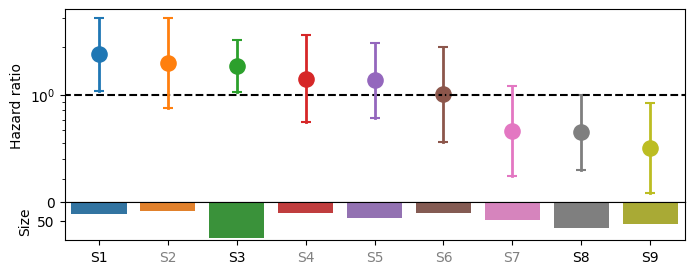

In [395]:
# Plot hazard ratio
num_significant = 0
color_palette = sns.color_palette("tab10") + sns.color_palette("Set2")
f, ax = plt.subplots(2, 1, height_ratios=[5, 1], figsize=(8, 3), sharex=True)
f.subplots_adjust(hspace=0)
ax[0].hlines(1, -1, len(HR), color="k", linestyle="--")
N, xticklabels, xtickcolors = [], [], []
for i in range(len(HR)):
    hr_dict = HR[i]
    subgroup_id = hr_dict['subgroup_id']
    hr, hr_lb, hr_ub, p = (
            hr_dict["hr"],
            hr_dict["hr_lower"],
            hr_dict["hr_upper"],
            hr_dict["p"],
        )
    ax[0].plot([i, i], [hr_lb, hr_ub], color=color_palette[i], linewidth=2)
    ax[0].scatter([i], [hr], color=color_palette[i], s=120)
    ax[0].scatter([i], [hr_lb], color=color_palette[i], s=60, marker="_")
    ax[0].scatter([i], [hr_ub], color=color_palette[i], s=60, marker="_")
    N.append(np.sum(Subgroup_ids_ == subgroup_id))
    xticklabels.append("S{}".format(int(subgroup_id)))
    if p < 0.05:
        xtickcolors.append("k")
        num_significant+=1
    else:
        xtickcolors.append("grey")
ax[0].set_xticks(range(len(HR)))
ax[0].set_xticklabels(xticklabels)
for xtick, color in zip(ax[1].get_xticklabels(), xtickcolors):
    xtick.set_color(color)
ax[0].set_xlabel("Patient Subgroups")
ax[0].set_ylabel("Hazard ratio")
ax[0].set_yscale("log")
# ax[1].set_title("Hazard ratios of Patient Subgroups")
DF = pd.DataFrame({"N": N, "subgroup_id": xticklabels})
g = sns.barplot(data=DF, x="subgroup_id", y="N", palette=color_palette, ax=ax[1])
g.invert_yaxis()
ax[1].set_ylabel("Size")
ax[1].set_xlabel("")
plt.show()

### Find Over-presented Patterns

In [396]:
Candidates = []
Candiates_overpresented_in_subgroup = []
from scipy import stats

for hr_dict in HR:
    subgroup_id = hr_dict["subgroup_id"]
    hr = hr_dict["hr"]
    p = hr_dict["p"]
    if p < 0.05:
        Histogram_intra_group = Histograms_[Subgroup_ids_ == subgroup_id]
        Histogram_out_group = Histograms_[Subgroup_ids_ != subgroup_id]
        for i in range(Histograms_.shape[1]):
            existence_intra_group = np.sum(Histogram_intra_group[:,i]>0)/Histogram_intra_group.shape[0]
            existence_out_group = np.sum(Histogram_out_group[:,i]>0)/Histogram_out_group.shape[0]
            
            rvsi = Histogram_intra_group[:, i]
            rvso = Histogram_out_group[:, i]
            ratio = np.mean(rvsi) / np.mean(rvso)
            result = stats.ttest_ind(rvsi, rvso, equal_var=False)
            if (result.pvalue < 0.05 / Histograms_.shape[1]) and (ratio > 1) :
                print(
                    "Pattern {} overpresented in {} by {:.3f} times (p={:.5f}), exist in {:.0f}% patients intra group, exist {:.0f}% out of group".format(
                        i, subgroup_id, ratio, result.pvalue, existence_intra_group*100, existence_out_group*100
                    )
                )
                Candidates.append(i)
                Candiates_overpresented_in_subgroup.append(subgroup_id)


print(Candidates)
print(Candiates_overpresented_in_subgroup)

Pattern 0 overpresented in 3 by 3.109 times (p=0.00000), exist in 99% patients intra group, exist 96% out of group
Pattern 1 overpresented in 3 by 19.530 times (p=0.00048), exist in 94% patients intra group, exist 62% out of group
Pattern 4 overpresented in 3 by 4.038 times (p=0.00000), exist in 98% patients intra group, exist 92% out of group
Pattern 18 overpresented in 3 by 5.159 times (p=0.00009), exist in 96% patients intra group, exist 57% out of group
Pattern 20 overpresented in 3 by 8.138 times (p=0.00010), exist in 88% patients intra group, exist 52% out of group
Pattern 22 overpresented in 3 by 4.811 times (p=0.00000), exist in 97% patients intra group, exist 84% out of group
Pattern 28 overpresented in 3 by 2.910 times (p=0.00000), exist in 97% patients intra group, exist 88% out of group
Pattern 41 overpresented in 3 by 3.584 times (p=0.00000), exist in 94% patients intra group, exist 78% out of group
Pattern 8 overpresented in 8 by 16.574 times (p=0.00000), exist in 100% pa

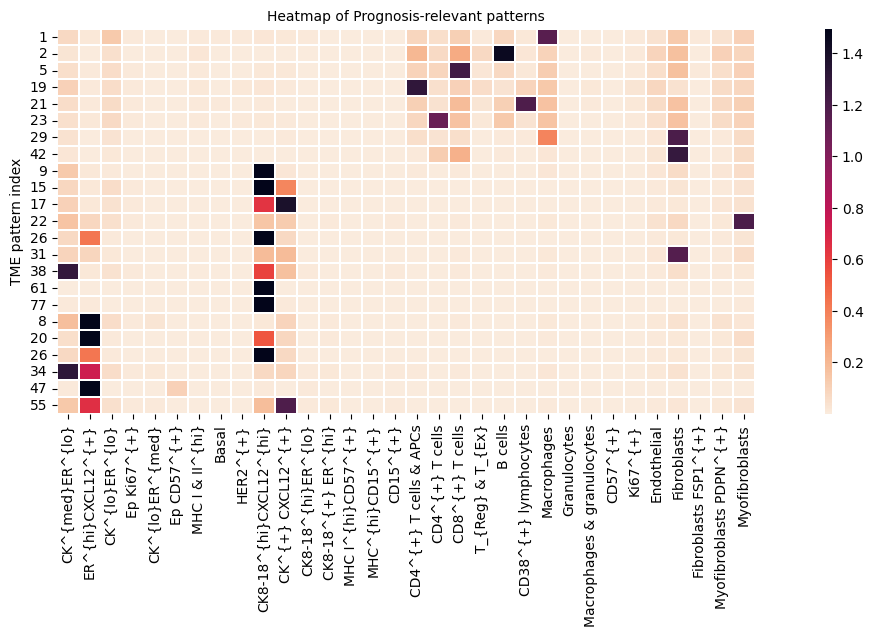

In [397]:
# Signature map before merging
from b_Soft_WL_Kernel.SoftWL import compute_cluster_centroids
from definitions import get_cell_phenotype_id

Centroids = compute_cluster_centroids(X, Cluster_identities)
Signature = Centroids.T
Cell_type_name_list = list(get_cell_phenotype_id('Danenberg'))
f, (ax, cbar_ax) = plt.subplots(1,2,figsize=(10,5),gridspec_kw= {"width_ratios": [20,0.2]} )
sns.heatmap(
        Signature[:, np.array(Candidates)].T,
        ax=ax,
        cbar_ax=cbar_ax,
        cmap="rocket_r",
        linewidth=0.005,
        edgecolor="black",
        vmax=np.percentile(Signature, 99),
        vmin=np.percentile(Signature, 1),
    )
ax.set_xticklabels(Cell_type_name_list, rotation=90, fontsize=10)
ax.set_yticklabels([i+1 for i in Candidates], fontsize=10)
ax.set_ylabel("TME pattern index", fontsize=10)
ax.set_title("Heatmap of Prognosis-relevant patterns", fontsize=10)
plt.show()

### Test these over-presented patterns

##### Split patients by presence

Pattern = 0, 50% percentile = 38.0000000
Pattern = 0, p-value = 0.3664595
Pattern = 1, 50% percentile = 3.0000000
Pattern = 1, p-value = 0.9753658
Pattern = 4, 50% percentile = 18.0000000
Pattern = 4, p-value = 0.0011530
Pattern = 18, 50% percentile = 3.0000000
Pattern = 18, p-value = 0.0306761
Pattern = 20, 50% percentile = 2.0000000
Pattern = 20, p-value = 0.8067589
Pattern = 22, 50% percentile = 9.0000000
Pattern = 22, p-value = 0.5195199
Pattern = 28, 50% percentile = 9.0000000
Pattern = 28, p-value = 0.0351565
Pattern = 41, 50% percentile = 6.0000000
Pattern = 41, p-value = 0.0255464
Pattern = 8, 50% percentile = 2.0000000
Pattern = 8, p-value = 0.0043898
Pattern = 14, 50% percentile = 2.0000000
Pattern = 14, p-value = 0.0016040
Pattern = 16, 50% percentile = 2.0000000
Pattern = 16, p-value = 0.0036291
Pattern = 21, 50% percentile = 14.0000000
Pattern = 21, p-value = 0.0142730
Pattern = 25, 50% percentile = 0.0000000
Pattern = 25, p-value = 0.0054420
Pattern = 30, 50% percentile =

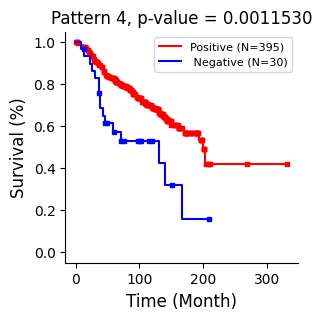

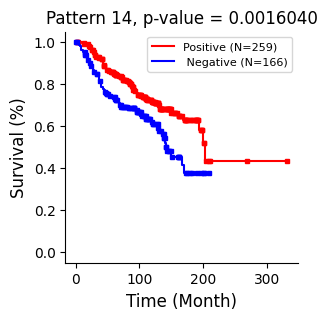

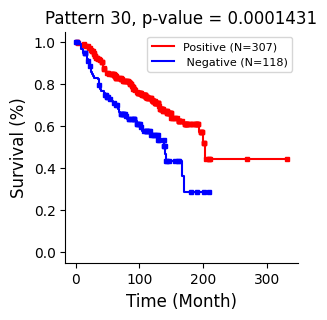

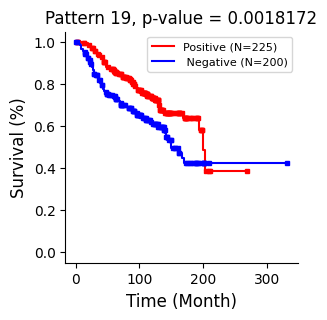

In [398]:

kmf = KaplanMeierFitter()
Candidates_1 = []
for pattern_id in Candidates:
    histogram_pattern = Histograms_[:, pattern_id]
    print("Pattern = {}, 50% percentile = {:.7f}".format(pattern_id, np.percentile(histogram_pattern, 50)))
    if 1:
        threshold = 0
        length_A, event_observed_A = (
            Length_[histogram_pattern > threshold],
            Status_[histogram_pattern > threshold],
        )
        length_B, event_observed_B = (
            Length_[histogram_pattern <= threshold],
            Status_[histogram_pattern <= threshold],
        )
        log_rank_test = multivariate_logrank_test(
            np.concatenate([length_A, length_B]),
            [0] * len(length_A) + [1] * len(length_B),
            np.concatenate([event_observed_A, event_observed_B]),
        )
        p_value = log_rank_test.p_value
        print("Pattern = {}, p-value = {:.7f}".format(pattern_id, p_value))
        if p_value <0.05/len(Candidates) :
            #print("Pattern = {}, p-value = {:.7f}".format(pattern_id, p_value))
            Candidates_1.append(pattern_id)
            f, ax = plt.subplots(figsize=(3, 3))
            kmf.fit(
                length_A, event_observed_A, label="Positive (N={})".format(len(length_A))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="red",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )

            kmf.fit(
                length_B, event_observed_B, label=" Negative (N={})".format(len(length_B))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color='blue',
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            ax.legend(fontsize = 8)
            ax.set_title(
                "Pattern {}, p-value = {:.7f}".format(pattern_id, p_value), fontsize=12
            )
            ax.set_xlabel("Time (Month)", fontsize=12)
            ax.set_ylabel("Survival (%)", fontsize=12)
            ax.set(
                ylim=(-0.05, 1.05),
            )
            sns.despine()
    else:
        threshold = np.percentile(histogram_pattern, 50)
        length_A, event_observed_A = (
            Length_[histogram_pattern > threshold],
            Status_[histogram_pattern > threshold],
        )
        length_B, event_observed_B = (
            Length_[histogram_pattern == 0],
            Status_[histogram_pattern == 0],
        )
        length_C, event_observed_C = (
            Length_[
                (histogram_pattern > 0)
                & (histogram_pattern <= threshold)
            ],
            Status_[
                (histogram_pattern > 0)
                & (histogram_pattern <= threshold)
            ],
        )
        log_rank_test1 = multivariate_logrank_test(
            np.concatenate([length_A, length_C]),
            [0] * len(length_A) + [2] * len(length_C),
            np.concatenate([event_observed_A,event_observed_C]),
        )
        log_rank_test2 = multivariate_logrank_test(
            np.concatenate([length_B, length_C]),
            [1] * len(length_B) + [2] * len(length_C),
            np.concatenate([event_observed_B,event_observed_C]),
        )
        log_rank_test = multivariate_logrank_test(
            np.concatenate([length_A, length_B, length_C]),
            [0] * len(length_A) + [1] * len(length_B) + [2] * len(length_C),
            np.concatenate([event_observed_A, event_observed_B, event_observed_C]),
        )
        p_value = log_rank_test.p_value
        print("Pattern = {}, p-value = {:.7f}".format(pattern_id, p_value))
        if p_value<0.05:
            print("Pattern = {}, p-value = {:.7f}".format(pattern_id, p_value))
            Candidates_1.append(pattern_id)
            f, ax = plt.subplots(figsize=(3, 3))
            kmf.fit(
                length_A, event_observed_A, label="High (N={})".format(len(length_A))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="red",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            kmf.fit(
                length_C, event_observed_C, label="Low (N={})".format(len(length_C))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="orange",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )

            kmf.fit(
                length_B, event_observed_B, label="Negative (N={})".format(len(length_B))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color='blue',
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            ax.legend(fontsize = 8)
            ax.set_title(
                "Pattern {}, p-value = {:.7f}".format(pattern_id, p_value), fontsize=12
            )
            ax.set_xlabel("Time (Month)", fontsize=12)
            ax.set_ylabel("Survival (%)", fontsize=12)
            ax.set(
                ylim=(-0.05, 1.05),
            )
            sns.despine()
print(Candidates_1)

##### Calculate hr

In [399]:
# DF = pd.DataFrame({
#     'length': Length_,
#     'status': Status_,
    
# })
# Candidates_1 = []
# for pattern_id in range(Histograms_.shape[1]):
#     DF["pattern_"+str(pattern_id)] = (Histograms_[:, pattern_id] - np.mean(Histograms_[:, pattern_id]))/np.std(Histograms_[:, pattern_id])
# cph = CoxPHFitter()
# cph.fit(DF, duration_col='length', event_col='status', formula=" + ".join(["pattern_"+str(i) for i in range(Histograms_.shape[1])]))
# cph.print_summary()
# for pattern_id in Candidates:
# if cph.summary["p"]["pattern_"+str(pattern_id)]<0.05/len(Candidates):
#     Candidates_1.append(pattern_id)
#     print("pattern id = {} (*), HR= {:.2f}, p={:.4f}".format(pattern_id, cph.hazard_ratios_["pattern_"+str(pattern_id)],cph.summary["p"]["pattern_"+str(pattern_id)]))
# else:
#     print("pattern id = {}, HR= {:.2f}, p={:.4f}".format(pattern_id, cph.hazard_ratios_["pattern_"+str(pattern_id)],cph.summary["p"]["pattern_"+str(pattern_id)] ))
# print(Candidates_1)

### Visualize prognosis-relevant patterns

In [400]:
def get_pos(G):
    x = nx.get_node_attributes(G, "X")
    y = nx.get_node_attributes(G, "Y")
    pos = {}
    for key, _ in x.items():
        pos[key] = (x[key], y[key])
    return pos
def normalize_pos(pos):
    x = np.array([pos[key][0] for key in pos.keys()])
    y = np.array([pos[key][1] for key in pos.keys()])
    x = x - x[-1]
    y = y - y[-1]
    pos_normalized = {}
    for i, key in enumerate(pos.keys()):
        pos_normalized[key] = (x[i], y[i])
    return pos_normalized


4 patient_345_image_35 307
14 patient_571_image_785 943
30 patient_915_image_349 601
19 patient_282_image_1 1260


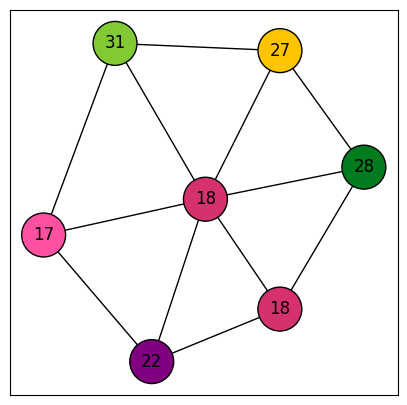

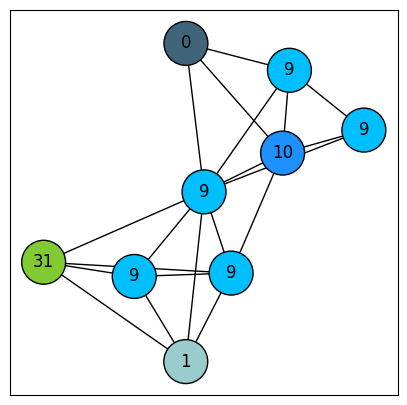

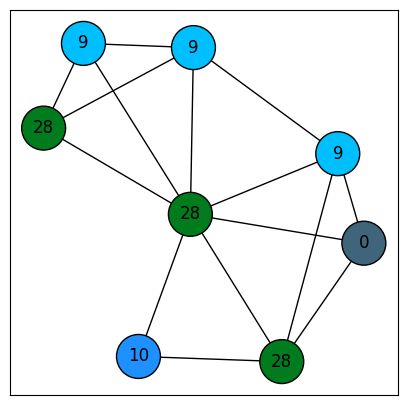

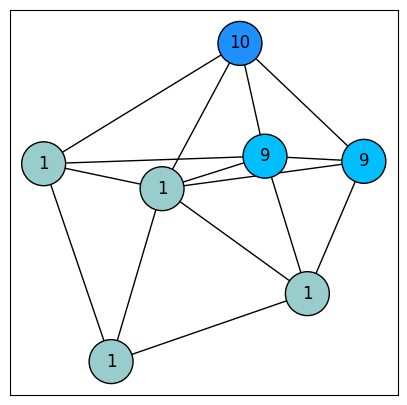

/cis/home/zwang/venv/cell-gnn/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


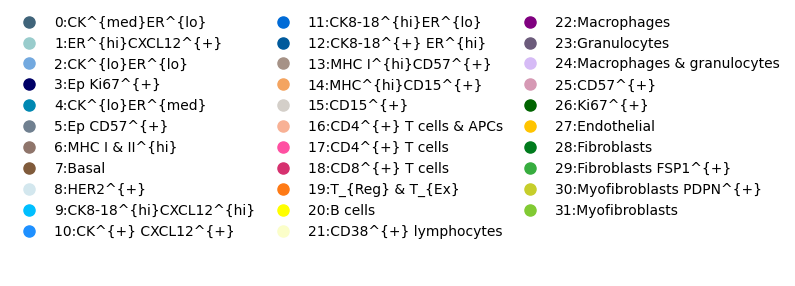

In [401]:
from definitions import get_cell_color
cell_color_dict = get_cell_color("Danenberg")
cell_type_dict = get_cell_phenotype_id("Danenberg")
Centroids = compute_cluster_centroids(X, Cluster_identities)
for pattern_id in Candidates_1:
    subtree_signature = Centroids[pattern_id,:]
    subtree_candidates = np.where(np.array(Cluster_identities) == pattern_id)[0]
    subtree_candidates_distance_to_signature = np.linalg.norm(
        X[subtree_candidates] - subtree_signature.reshape((1, -1)),
        axis=1,
    )
    subtree_global_idx = subtree_candidates[
        np.argsort(subtree_candidates_distance_to_signature)[:1]
    ][0]
    file_name = FILE_NAMES[Indices[subtree_global_idx]]
    subtree_local_idx = (
            subtree_global_idx - np.where(Indices == Indices[subtree_global_idx])[0][0]
        )
    #--------------------------------------
    patient_id = int(file_name.split("_")[1])
    image_id = int(file_name.split("_")[3])
    cells_ = pd.read_csv(
        os.path.join(
            PROJECT_ROOT,
            "Input",
            "Single-cell",
            "Danenberg",
            "patient_{}_image_{}.csv".format(patient_id, image_id),
        )
    )
    Adj = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "a_Cellular_graph",
            "Danenberg",
            "Cohort_1",
            "patient_{}_image_{}".format(patient_id, image_id),
            "Adj.npy",
        )
    )
    Adj_ = Adj.copy()
    Adj_[Adj_ < 0.01] = 0
    np.fill_diagonal(Adj_, 0)
    G = nx.from_numpy_array(Adj_)
    nx.set_node_attributes(G, cells_["X"], "X")
    nx.set_node_attributes(G, cells_["Y"], "Y")
    nx.set_node_attributes(G, cells_["cell_type"], "cell_type")
    nx.set_node_attributes(G, cells_["cell_type_id"], "cell_type_id")
    
    W =  Adj.copy()
    for i in range(iteration):
        W = np.matmul(W, Adj)
    leaf_idx = list(np.where(W[subtree_local_idx, :] > 0.1)[0])
    subtree = nx.subgraph(G, leaf_idx + [subtree_local_idx])
    f, ax = plt.subplots(figsize=(5,5))
    nx.draw_networkx(
        subtree,
        normalize_pos(get_pos(subtree)),
        node_size=1000,
        node_color=[
            cell_color_dict[cell_type]
            for cell_type in list(nx.get_node_attributes(subtree, "cell_type").values())
        ],
        labels = nx.get_node_attributes(subtree, "cell_type_id"),
        with_labels = True,
        edgecolors="black",
        ax=ax,
    )
    #nx.draw_networkx_edges(subtree, normalize_pos(get_pos(subtree)), ax=ax, alpha=0.5)
    print(pattern_id, file_name, subtree_local_idx)

fig, ax = plt.subplots(figsize=(10, 0.4), tight_layout=True)
f = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
cell_types = [str(cell_type_id)+':'+cell_type for cell_type, cell_type_id in cell_type_dict.items()]
colors = [cell_color_dict[cell_type] for cell_type, cell_type_id in cell_type_dict.items()]
handles = [f("o", colors[i]) for i in range(len(cell_types))]
ax.legend(
        handles,
        cell_types,
        loc=3,
        framealpha=0,
        frameon=1,
        ncols=3,
        bbox_to_anchor=(0, 1.02, 1, 0.2),
        mode="expand",
        borderaxespad=0.0,
        fontsize=10,
    )
ax.axis("off")
plt.show()

# Cohort 2

In [402]:
SoftWL_dict_cohort2 = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_2",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_cohort2 = SoftWL_dict_cohort2["Patient_id"]
Histograms_cohort2 = SoftWL_dict_cohort2["Histogram"]

Patient_Inclusion_mask_cohort2 = np.ones(len(Patient_IDs_cohort2), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_cohort2]
    patient_inclusion_mask_cohort2 = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_cohort2 = Patient_Inclusion_mask_cohort2 * patient_inclusion_mask_cohort2
Patient_IDs_cohort2 = np.array(Patient_IDs_cohort2)[Patient_Inclusion_mask_cohort2]
Histograms_cohort2 = Histograms_cohort2[Patient_Inclusion_mask_cohort2, :]
print("{} patients are included".format(len(Patient_IDs_cohort2)))

if survival_type == 'Overall':
    Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival (Months)'].values[0] for i in Patient_IDs_cohort2]
    Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival Status'].values[0] for i in Patient_IDs_cohort2]  
elif survival_type == 'Relpase-free':
    Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status (Months)'].values[0] for i in Patient_IDs_cohort2]
    Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status'].values[0] for i in Patient_IDs_cohort2] 
elif survival_type == 'Disease-specific':
    Length_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival (Months)'].values[0] for i in Patient_IDs_cohort2]
    Status_cohort2 = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival Status'].values[0] for i in Patient_IDs_cohort2]
DF_cohort2 = pd.DataFrame({"Length": Length_cohort2, "Status": Status_cohort2}).dropna()
Length_cohort2_ = np.array(DF_cohort2["Length"])
Status_cohort2_ = np.array(DF_cohort2["Status"])
Histograms_cohort2_ = Histograms_cohort2[DF_cohort2.index.values, :]
Patient_IDs_cohort2_ = np.array(Patient_IDs_cohort2)[DF_cohort2.index.values]


154 patients are included


Pattern = 4, p-value = 0.4852421
Pattern = 14, p-value = 0.0279138
Pattern = 30, p-value = 0.0035839
Pattern = 19, p-value = 0.4218901


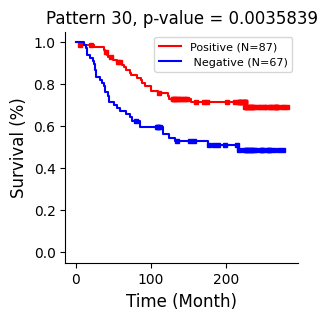

In [403]:
kmf = KaplanMeierFitter()
for pattern_id in Candidates_1:
    histogram_pattern = Histograms_cohort2_[:, pattern_id]
    if 1:
        threshold = 0
        length_A, event_observed_A = (
            Length_cohort2_[histogram_pattern > threshold],
            Status_cohort2_[histogram_pattern > threshold],
        )
        length_B, event_observed_B = (
            Length_cohort2_[histogram_pattern <= threshold],
            Status_cohort2_[histogram_pattern <= threshold],
        )
        log_rank_test = multivariate_logrank_test(
            np.concatenate([length_A, length_B]),
            [0] * len(length_A) + [1] * len(length_B),
            np.concatenate([event_observed_A, event_observed_B]),
        )
        p_value = log_rank_test.p_value
        print("Pattern = {}, p-value = {:.7f}".format(pattern_id, p_value))
        if p_value < 0.05/len(Candidates_1):
            f, ax = plt.subplots(figsize=(3, 3))
            kmf.fit(
                length_A, event_observed_A, label="Positive (N={})".format(len(length_A))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="red",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )

            kmf.fit(
                length_B, event_observed_B, label=" Negative (N={})".format(len(length_B))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color='blue',
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            ax.legend(ncol=1, fontsize=8)
            ax.set_title(
                "Pattern {}, p-value = {:.7f}".format(pattern_id, p_value), fontsize=12
            )
            ax.set_xlabel("Time (Month)", fontsize=12)
            ax.set_ylabel("Survival (%)", fontsize=12)
            ax.set(
                ylim=(-0.05, 1.05),
            )
            sns.despine()
    else:
        threshold = np.percentile(histogram_pattern[histogram_pattern>0], 50)
        length_A, event_observed_A = (
            Length_cohort2_[histogram_pattern > threshold],
            Status_cohort2_[histogram_pattern > threshold],
        )
        length_B, event_observed_B = (
            Length_cohort2_[histogram_pattern == 0],
            Status_cohort2_[histogram_pattern == 0],
        )
        length_C, event_observed_C = (
            Length_cohort2_[
                (histogram_pattern > 0)
                & (histogram_pattern <= threshold)
            ],
            Status_cohort2_[
                (histogram_pattern > 0)
                & (histogram_pattern <= threshold)
            ],
        )
        log_rank_test = multivariate_logrank_test(
            np.concatenate([length_A, length_B, length_C]),
            [0] * len(length_A) + [1] * len(length_B) + [2] * len(length_C),
            np.concatenate([event_observed_A, event_observed_B, event_observed_C]),
        )
        p_value = log_rank_test.p_value
        print("Pattern = {}, p-value = {:.7f}".format(pattern_id, p_value))
        if p_value:
            f, ax = plt.subplots(figsize=(3, 3))
            kmf.fit(
                length_A, event_observed_A, label="High (N={})".format(len(length_A))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="red",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            kmf.fit(
                length_C, event_observed_C, label="Low (N={})".format(len(length_C))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="orange",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )

            kmf.fit(
                length_B, event_observed_B, label=" Negative (N={})".format(len(length_B))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color='blue',
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            ax.legend(ncol=1, fontsize=8)
            ax.set_title(
                "Pattern {}, p-value = {:.7f}".format(pattern_id, p_value), fontsize=12
            )
            ax.set_xlabel("Time (Month)", fontsize=12)
            ax.set_ylabel("Survival (%)", fontsize=12)
            ax.set(
                ylim=(-0.05, 1.05),
            )
            sns.despine()

# Jackson

In [404]:
SoftWL_dict_jackson = pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Jackson",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + "_centroid_alignment.pkl",
        ),
        "rb",
    ),
)
Patient_IDs_jackson = SoftWL_dict_jackson["Patient_id"]
Histograms_jackson = SoftWL_dict_jackson["Histogram"]
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Jackson",
        "clinical.csv",
    )
)
clinical.rename(columns={'ERStatus': 'ER Status'}, inplace=True)
clinical.rename(columns={'HER2Status': 'HER2 Status'}, inplace=True)
clinical['ER Status'] = clinical['ER Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['HER2 Status'] = clinical['HER2 Status'].map({'positive': 'Positive', 'negative': 'Negative'})
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
clinical['Relapse Free Status'] = clinical['Relapse Free Status'].map({'0:Not Recurred':0, '1:Recurred':1})

Patient_Inclusion_mask_jackson = np.ones(len(Patient_IDs_jackson), dtype=bool)
for feature, included_values in patient_filtering_dict.items():
    Feature = [clinical.loc[clinical['patient_id'] == patient_id, feature].values[0] for patient_id in Patient_IDs_jackson]
    patient_inclusion_mask_jackson = np.array([feature  == included_values for feature in Feature])
    Patient_Inclusion_mask_jackson = Patient_Inclusion_mask_jackson * patient_inclusion_mask_jackson
Patient_IDs_jackson = np.array(Patient_IDs_jackson)[Patient_Inclusion_mask_jackson]
Histograms_jackson = Histograms_jackson[Patient_Inclusion_mask_jackson, :]

if survival_type == "Overall" or survival_type == "Disease-specific":
    Length_jackson = [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival (Months)"].values[0]
        for i in Patient_IDs_jackson
    ]
    Status_jackson = [
        clinical.loc[clinical["patient_id"] == i, "Overall Survival Status"].values[0]
        for i in Patient_IDs_jackson
    ]
elif survival_type == "Relpase-free":
    Length_jackson = [
        clinical.loc[
            clinical["patient_id"] == i, "Relapse Free Status (Months)"
        ].values[0]
        for i in Patient_IDs_jackson
    ]
    Status_jackson = [
        clinical.loc[clinical["patient_id"] == i, "Relapse Free Status"].values[0]
        for i in Patient_IDs_jackson
    ]
DF_jackson = pd.DataFrame({"Length": Length_jackson, "Status": Status_jackson}).dropna()
Length_jackson_ = np.array(DF_jackson["Length"])
Status_jackson_ = np.array(DF_jackson["Status"])
Histograms_jackson_ = Histograms_jackson[DF_jackson.index.values, :]
Patient_IDs_jackson_ = np.array(Patient_IDs_jackson)[DF_jackson.index.values]
print("{} patients are included".format(len(Patient_IDs_jackson_)))

266 patients are included


8.0
Pattern = 4, p-value = 0.7808017
0.0
Pattern = 14, p-value = 0.0038515
1.0
Pattern = 30, p-value = 0.0001175
0.0
Pattern = 19, p-value = 0.0755835


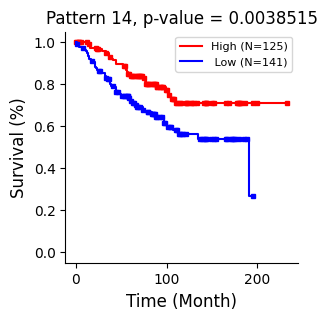

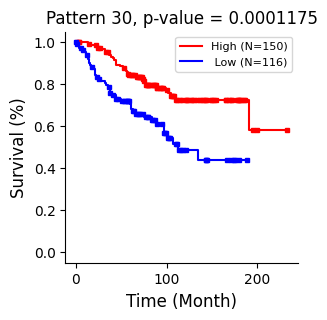

In [405]:
kmf = KaplanMeierFitter()
for pattern_id in Candidates_1:
    histogram_pattern = Histograms_jackson_[:, pattern_id]
    print(np.percentile(histogram_pattern, 50))
    if 1:
        threshold = 0
        length_A, event_observed_A = (
            Length_jackson_[histogram_pattern > threshold],
            Status_jackson_[histogram_pattern > threshold],
        )
        length_B, event_observed_B = (
            Length_jackson_[histogram_pattern <= threshold],
            Status_jackson_[histogram_pattern <= threshold],
        )
        log_rank_test = multivariate_logrank_test(
            np.concatenate([length_A, length_B]),
            [0] * len(length_A) + [1] * len(length_B),
            np.concatenate([event_observed_A, event_observed_B]),
        )
        p_value = log_rank_test.p_value
        print("Pattern = {}, p-value = {:.7f}".format(pattern_id, p_value))
        if p_value< 0.05/len(Candidates_1) :
            f, ax = plt.subplots(figsize=(3, 3))
            kmf.fit(
                length_A, event_observed_A, label="High (N={})".format(len(length_A))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="red",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )

            kmf.fit(
                length_B, event_observed_B, label=" Low (N={})".format(len(length_B))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color='blue',
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            ax.legend(ncol=1, fontsize=8)
            ax.set_title(
                "Pattern {}, p-value = {:.7f}".format(pattern_id, p_value), fontsize=12
            )
            ax.set_xlabel("Time (Month)", fontsize=12)
            ax.set_ylabel("Survival (%)", fontsize=12)
            ax.set(
                ylim=(-0.05, 1.05),
            )
            sns.despine()
    else:
        threshold = np.percentile(histogram_pattern[histogram_pattern>0], 50)
        length_A, event_observed_A = (
            Length_jackson_[histogram_pattern > threshold],
            Status_jackson_[histogram_pattern > threshold],
        )
        length_B, event_observed_B = (
            Length_jackson_[histogram_pattern == 0],
            Status_jackson_[histogram_pattern == 0],
        )
        length_C, event_observed_C = (
            Length_jackson_[
                (histogram_pattern > 0)
                & (histogram_pattern <= threshold)
            ],
            Status_jackson_[
                (histogram_pattern > 0)
                & (histogram_pattern <= threshold)
            ],
        )
        log_rank_test = multivariate_logrank_test(
            np.concatenate([length_A, length_B, length_C]),
            [0] * len(length_A) + [1] * len(length_B) + [2] * len(length_C),
            np.concatenate([event_observed_A, event_observed_B, event_observed_C]),
        )
        p_value = log_rank_test.p_value
        print("Pattern = {}, p-value = {:.7f}".format(pattern_id, p_value))
        if p_value < 0.05/len(Candidates_1):
            f, ax = plt.subplots(figsize=(3, 3))
            kmf.fit(
                length_A, event_observed_A, label="High (N={})".format(len(length_A))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="red",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            kmf.fit(
                length_C, event_observed_C, label="Low (N={})".format(len(length_C))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color="orange",
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )

            kmf.fit(
                length_B, event_observed_B, label=" Negative (N={})".format(len(length_B))
            )
            kmf.plot_survival_function(
                ax=ax,
                ci_show=False,
                color='blue',
                show_censors=True,
                censor_styles={"ms": 3, "marker": "s"},
            )
            ax.legend(ncol=2, fontsize=10)
            ax.set_title(
                "Pattern {}, p-value = {:.7f}".format(pattern_id, p_value), fontsize=12
            )
            ax.set_xlabel("Time (Month)", fontsize=12)
            ax.set_ylabel("Survival (%)", fontsize=12)
            ax.set(
                ylim=(-0.05, 1.05),
            )
            sns.despine()

# Other (probably) useful information

### KM-Plots

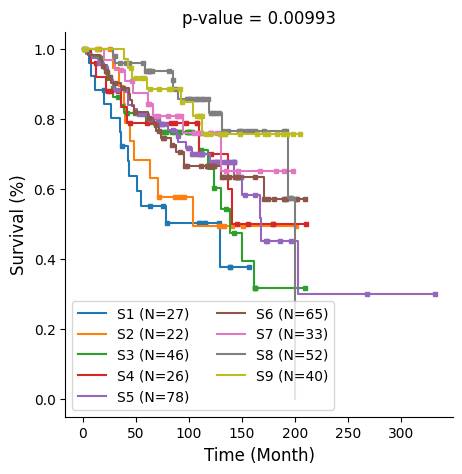

In [203]:

kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
for i, hr_dict in enumerate(HR):
    subgroup_id = hr_dict['subgroup_id']
    length_A, event_observed_A = (
            Length_[Subgroup_ids_ == subgroup_id],
            Status_[Subgroup_ids_ == subgroup_id],
        )
    label = "S{} (N={})".format(hr_dict["subgroup_id"], np.sum(Subgroup_ids_ == subgroup_id))
    kmf.fit(length_A, event_observed_A, label=label)
    kmf.plot_survival_function(ax=ax, ci_show=False, color=color_palette[i],
    show_censors=True,
            censor_styles={"ms": 3, "marker": "s"})
log_rank_test  = multivariate_logrank_test(
        Length_[Subgroup_ids_!=0], Subgroup_ids_[Subgroup_ids_!=0],Status_[Subgroup_ids_!=0]
    )
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

### Population Graph

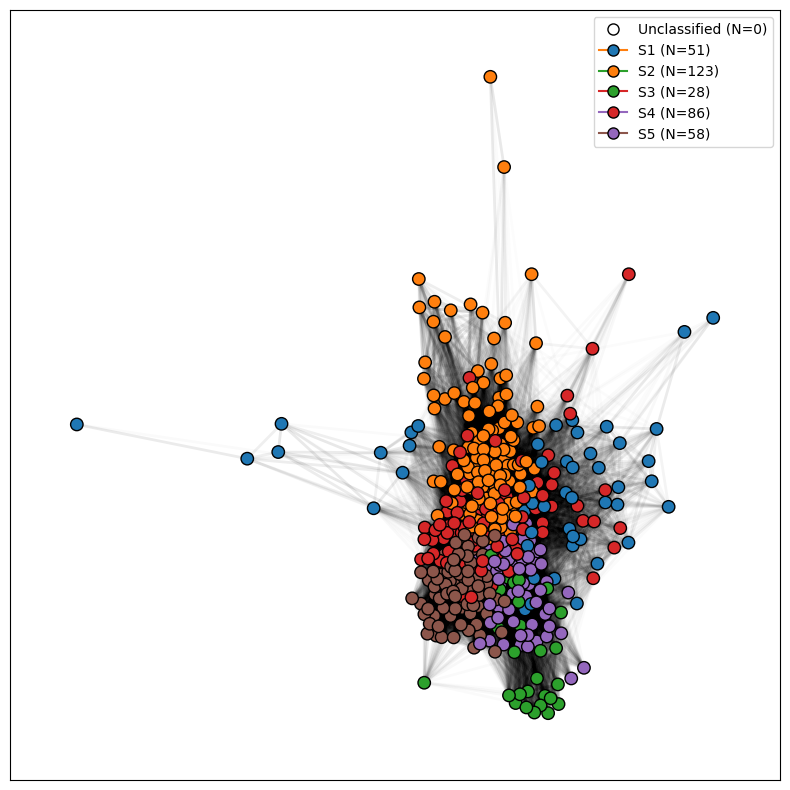

In [361]:
color_palette = ["white"] + sns.color_palette("tab10") + sns.color_palette("Set2")
pos = nx.spring_layout(G_population, seed=2, k=1 / np.sqrt(682) * 5, iterations=100)
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
edge_list = list(G_population.edges())
edge_alpha = [
        0.1 * G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0 else 0 for u, v in edge_list
    ]
nx.draw_networkx_edges(G_population, pos, alpha=edge_alpha, width=2)
nx.draw_networkx_nodes(
            G_population, pos, node_size=80, 
            node_color=[color_palette[int(i)] for i in Subgroup_ids], 
            edgecolors="black"
        )
handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[0],
        label=f"Unclassified (N={np.sum(Subgroup_ids == 0)})",
        markerfacecolor=color_palette[0],
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    )
]
for i in range(1, len(np.unique(Subgroup_ids))):
    patch = Line2D(
        [0],
        [0],
        marker="o",
        color=color_palette[i + 1],
        label=f"S{i} (N={np.sum(Subgroup_ids == i)})",
        markerfacecolor=color_palette[i],
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    )
    handles.append(patch)
ax.legend(handles=handles)
plt.show()

In [521]:
# Histograms_ = (Histograms_ - np.mean(Histograms_, axis=0))/np.std(Histograms_, axis=0)
DF = pd.DataFrame({
    'length': Length_,
    'status': Status_,
})
for pattern_id in Candidates:
    DF["pattern_"+str(pattern_id)] = Histograms_[:, pattern_id]
cph = CoxPHFitter()
cph.fit(DF, duration_col='length', event_col='status', formula=" + ".join(["pattern_"+str(i) for i in Candidates]))
print(cph.print_summary())

<lifelines.CoxPHFitter: fitted with 369 total observations, 189 right-censored observations>
             duration col = 'length'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 369
number of events observed = 180
   partial log-likelihood = -938.75
         time fit was run = 2023-11-03 01:07:38 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
pattern_10  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_15  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_16   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_18   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_22  -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
pattern_23  -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
pattern_28   0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
pattern_35  -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00

             cmp to     z    p   -log2(p)
covariate                                
pattern_10     0.00 -0.16 0.88       0.19
pattern_15     0.00 -0.92 0.36       1.49
pattern_16     0.00  1.60 0.11       3.20
pattern_18     0.00  0.48 0.63       0.66
pattern_22     0.00 -1.67 0.09       3.40
pattern_23     0.00 -2.08 0.04       4.74
pattern_28     0.00  2.67 0.01       7.04
pattern_35     0.00 -1.84 0.07       3.92
---
Concordance = 0.59
Partial AIC = 1893.49
log-likelihood ratio test = 19.64 on 8 df
-log2(p) of ll-ratio test = 6.41

None
